In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE


In [3]:
data_path = "bank-additional-full.csv"
data = pd.read_csv(data_path, sep=';')

print("Dataset Overview:")
print(data.info())
print("\nSample Data:")
print(data.head())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx

In [5]:
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    if column != 'y':
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le

# Encode target variable
data['y'] = data['y'].apply(lambda x: 1 if x == 'yes' else 0)


In [7]:
X = data.drop('y', axis=1)
y = data['y']


In [9]:
# Handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Hyperparameter tuning (removed Support Vector Machine)
grid_params = {
    'K-Nearest Neighbors': {'n_neighbors': [3, 5]},
    'Decision Tree': {'max_depth': [5, 10]}
}


In [15]:
results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    grid = GridSearchCV(model, grid_params[model_name], cv=3, scoring='roc_auc')  # Reduced CV fold for faster tuning
    grid.fit(X_train_scaled if model_name == 'K-Nearest Neighbors' else X_train, y_train)
    best_model = grid.best_estimator_
    predictions = best_model.predict(X_test_scaled if model_name == 'K-Nearest Neighbors' else X_test)
    
    # Evaluate
    print(f"Best Parameters for {model_name}: {grid.best_params_}")
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, predictions))
    roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test_scaled if model_name == 'K-Nearest Neighbors' else X_test)[:, 1])
    print(f"ROC-AUC Score for {model_name}: {roc_auc:.4f}")
    results[model_name] = {
        'model': best_model,
        'roc_auc': roc_auc
    }



Training K-Nearest Neighbors...
Best Parameters for K-Nearest Neighbors: {'n_neighbors': 5}
Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      7332
           1       0.90      0.95      0.92      7288

    accuracy                           0.92     14620
   macro avg       0.92      0.92      0.92     14620
weighted avg       0.92      0.92      0.92     14620

ROC-AUC Score for K-Nearest Neighbors: 0.9656

Training Decision Tree...
Best Parameters for Decision Tree: {'max_depth': 10}
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      7332
           1       0.90      0.94      0.92      7288

    accuracy                           0.92     14620
   macro avg       0.92      0.92      0.92     14620
weighted avg       0.92      0.92      0.92     14620

ROC-AUC Score for Decision Tree: 0.9610

In [17]:
print("\nModel Comparison:")
comparison = pd.DataFrame.from_dict({k: v['roc_auc'] for k, v in results.items()}, orient='index', columns=['ROC-AUC']).sort_values(by='ROC-AUC', ascending=False)
print(comparison)



Model Comparison:
                      ROC-AUC
K-Nearest Neighbors  0.965553
Decision Tree        0.961049


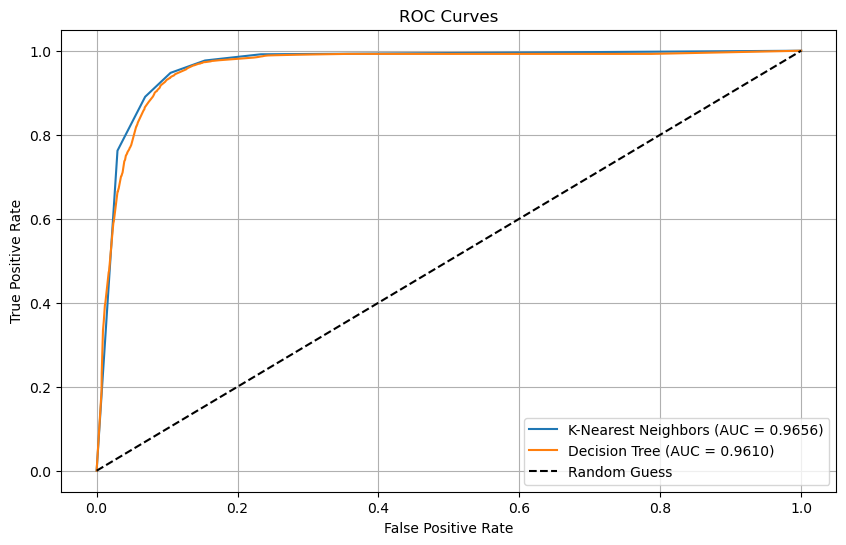

In [19]:
plt.figure(figsize=(10, 6))
for model_name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['model'].predict_proba(X_test_scaled if model_name == 'K-Nearest Neighbors' else X_test)[:, 1])
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {result['roc_auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()


In [21]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Hyperparameter tuning for Logistic Regression
log_reg_params = {
    'C': [0.1, 1, 10], 
    'solver': ['lbfgs', 'saga'],
    'max_iter': [500, 1000]
}

# Grid search with cross-validation
log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=3, scoring='roc_auc')
log_reg_grid.fit(X_train_scaled, y_train)

# Best model and predictions
best_log_reg_model = log_reg_grid.best_estimator_
log_reg_predictions = best_log_reg_model.predict(X_test_scaled)

# Evaluation
print(f"Best Parameters for Logistic Regression: {log_reg_grid.best_params_}")
print(f"Classification Report for Logistic Regression:")
print(classification_report(y_test, log_reg_predictions))

# ROC-AUC Score
log_reg_roc_auc = roc_auc_score(y_test, best_log_reg_model.predict_proba(X_test_scaled)[:, 1])
print(f"ROC-AUC Score for Logistic Regression: {log_reg_roc_auc:.4f}")


Best Parameters for Logistic Regression: {'C': 10, 'max_iter': 1000, 'solver': 'saga'}
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      7332
           1       0.88      0.89      0.89      7288

    accuracy                           0.89     14620
   macro avg       0.89      0.89      0.89     14620
weighted avg       0.89      0.89      0.89     14620

ROC-AUC Score for Logistic Regression: 0.9505
